# Programmers Skill Check Assignments 
## 채용공고추천

* Dataset 정보

```
1. train.csv  
userID : 개발자의 ID
jobID : 구직공고의 ID
applied : 지원 여부

2. job_tags.csv
jobID : 구직공고의 ID
tagID : 직업에 해당하는 키워드

3. user_tags.csv
user_ID : 개발자의 ID
tagID: 각 개발자가 관심사로 등록한 키워드

4. tags.csv 
tagID : 키워드
keyword : 키워드가 실제로 무엇을 의미하는지

5. job_companies.csv
companyID : 회사
jobID : 회사의 구직공고
companySize : 회사의 규모

6. test_job.csv 
userID : 개발자의 ID
jobID : 구직공고의 ID
```

In [1]:
!pip install gensim

In [2]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import missingno

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from gensim.models import Word2Vec

In [3]:
train = pd.read_csv("train.csv")
job_tags = pd.read_csv("job_tags.csv")
user_tags = pd.read_csv("user_tags.csv")
tags = pd.read_csv("tags.csv")
job_companies =  pd.read_csv("job_companies.csv")
test_job = pd.read_csv("test_job.csv")

## 데이터 확인

In [4]:
train.head()

,userID,jobID,applied
0,fe292163d06253b716e9a0099b42031d,15de21c670ae7c3f6f3f1f37029303c9,0
1,6377fa90618fae77571e8dc90d98d409,55b37c5c270e5d84c793e486d798c01d,0
2,8ec0888a5b04139be0dfe942c7eb4199,0fcbc61acd0479dc77e3cccc0f5ffca7,1
3,f862b39f767d3a1991bdeb2ea1401c9c,3b5dca501ee1e6d8cd7b905f4e1bf723,0
4,cac14930c65d72c16efac2c51a6b7f71,287e03db1d99e0ec2edb90d079e142f3,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   userID   6000 non-null   object
 1   jobID    6000 non-null   object
 2   applied  6000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 140.8+ KB


In [6]:
print(f"고유 아이디 수: {len(train.userID.unique())}")
print(f"고유 채용 공고 수: {len(train.jobID.unique())}")

고유 아이디 수: 196
고유 채용 공고 수: 708


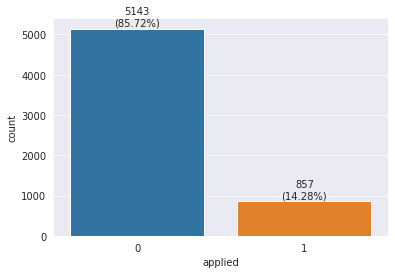

In [7]:
sns.countplot(train["applied"])
object_cnt = train["applied"].value_counts()
for x,y,z in zip(object_cnt.index, object_cnt.values, object_cnt.values/object_cnt.sum()*100):
    plt.annotate(f"{y}\n({round(z,2)}%)", xy=(x,y+70), textcoords="data", ha="center")

* 학습 데이터는 6천개가 있으며, 고유 아이디 수는 196개, 채용 공고는 708개가 있다.
* 지원하지 않는 경우가 전체 데이터의 약 85%를 차지하고 있다.
* 887개의 고유 태그가 있고, 채용공고에 선택된 태그는 3477개, 유저가 선택한 태그는 17194개가 있다.

In [8]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tagID    887 non-null    object
 1   keyword  887 non-null    object
dtypes: object(2)
memory usage: 14.0+ KB


In [9]:
job_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733 entries, 0 to 732
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   companyID    733 non-null    object
 1   jobID        733 non-null    object
 2   companySize  643 non-null    object
dtypes: object(3)
memory usage: 17.3+ KB


In [10]:
job_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3477 entries, 0 to 3476
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   jobID   3477 non-null   object
 1   tagID   3477 non-null   object
dtypes: object(2)
memory usage: 54.5+ KB


* 유저 별 지원한(applied=1) 채용공고 리스트 추출

In [11]:
user_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17194 entries, 0 to 17193
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userID  17194 non-null  object
 1   tagID   17194 non-null  object
dtypes: object(2)
memory usage: 268.8+ KB


* job_company의 companySize를 제외하고 결측치 없음
* 태그 중복 확인

In [12]:
print("user_tags 중복 개수:", user_tags.duplicated().sum())
print("job_tags 중복 개수:", job_tags.duplicated().sum())
print("job_companies 중복 개수:", job_companies.duplicated().sum())
print("train 중복 개수:", train.duplicated().sum())

user_tags 중복 개수: 14612
job_tags 중복 개수: 0
job_companies 중복 개수: 0
train 중복 개수: 0


user_tags에 14612개의 중복이 있으므로 중복 제거

In [13]:
user_tags = user_tags.drop_duplicates().reset_index(drop=True)
user_tags

,userID,tagID
0,e576423831e043f7928d9ac113abbe6f,82c2559140b95ccda9c6ca4a8b981f1e
1,e576423831e043f7928d9ac113abbe6f,2ba8698b79439589fdd2b0f7218d8b07
2,e576423831e043f7928d9ac113abbe6f,351b33587c5fdd93bd42ef7ac9995a28
3,e576423831e043f7928d9ac113abbe6f,81e5f81db77c596492e6f1a5a792ed53
4,e576423831e043f7928d9ac113abbe6f,0e095e054ee94774d6a496099eb1cf6a
...,...,...
2577,76d7c120cc635913a4911b28540ebbfe,c8ba76c279269b1c6bc8a07e38e78fa4
2578,76d7c120cc635913a4911b28540ebbfe,38ca89564b2259401518960f7a06f94b
2579,76d7c120cc635913a4911b28540ebbfe,0e095e054ee94774d6a496099eb1cf6a
2580,76d7c120cc635913a4911b28540ebbfe,884d79963bd8bc0ae9b13a1aa71add73


In [14]:
print("user_tags 중복 개수:", user_tags.duplicated().sum())

user_tags 중복 개수: 0


* userID와 jobID 변환 : 아이디가 너무 길어서 보기 힘드므로 짧게 변환

In [15]:
user_ids = pd.Series([x+1 for x in range(len(train["userID"].unique()))])
user_ids.index = train["userID"].unique()
user_id_dict = user_ids.to_dict()
str(user_id_dict)[:300]

"{'fe292163d06253b716e9a0099b42031d': 1, '6377fa90618fae77571e8dc90d98d409': 2, '8ec0888a5b04139be0dfe942c7eb4199': 3, 'f862b39f767d3a1991bdeb2ea1401c9c': 4, 'cac14930c65d72c16efac2c51a6b7f71': 5, 'ed1ca6971578b1da0e4ad55b48d77fda': 6, '8109c2c482264f96f8ac69a9a99db308': 7, '14ccd7a3d2daa57d06f4741f0"

In [16]:
job_ids = pd.Series([x+1 for x in range(len(job_tags["jobID"].unique()))])
job_ids.index = job_tags["jobID"].unique()
job_id_dict = job_ids.to_dict()
str(job_id_dict)[:300]

"{'320722549d1751cf3f247855f937b982': 1, 'e744f91c29ec99f0e662c9177946c627': 2, 'e820a45f1dfc7b95282d10b6087e11c0': 3, '53c3bce66e43be4f209556518c2fcb54': 4, 'fd06b8ea02fe5b1c2496fe1700e9d16c': 5, '6e7d2da6d3953058db75714ac400b584': 6, '818f4654ed39a1c147d1e51a00ffb4cb': 7, '019d385eb67632a7e958e23f2"

In [17]:
company_ids = pd.Series([x+1 for x in range(len(job_companies["companyID"].unique()))])
company_ids.index = job_companies["companyID"].unique()
company_id_dict = company_ids.to_dict()
str(company_id_dict)[:300]

"{'00411460f7c92d2124a67ea0f4cb5f85': 1, '1905aedab9bf2477edc068a355bba31a': 2, '89fcd07f20b6785b92134bd6c1d0fa42': 3, 'acf4b89d3d503d8252c9c4ba75ddbf6d': 4, 'fb7b9ffa5462084c5f4e7e85a093e6d7': 5, 'ac627ab1ccbdb62ec96e702f07f6425b': 6, '9ad6aaed513b73148b7d49f70afcfb32': 7, 'd707329bece455a462b58ce00"

In [18]:
train["userID"].replace(user_id_dict, inplace=True)
train["jobID"].replace(job_id_dict, inplace=True)
job_tags["jobID"].replace(job_id_dict, inplace=True)
user_tags["userID"].replace(user_id_dict, inplace=True)
job_companies["jobID"].replace(job_id_dict, inplace=True)
job_companies["companyID"].replace(company_id_dict, inplace=True)
test_job["userID"].replace(user_id_dict, inplace=True)
test_job["jobID"].replace(job_id_dict, inplace=True)

In [19]:
str(job_id_dict)[:300]

"{'320722549d1751cf3f247855f937b982': 1, 'e744f91c29ec99f0e662c9177946c627': 2, 'e820a45f1dfc7b95282d10b6087e11c0': 3, '53c3bce66e43be4f209556518c2fcb54': 4, 'fd06b8ea02fe5b1c2496fe1700e9d16c': 5, '6e7d2da6d3953058db75714ac400b584': 6, '818f4654ed39a1c147d1e51a00ffb4cb': 7, '019d385eb67632a7e958e23f2"

In [20]:
train.head()

,userID,jobID,applied
0,1,372,0
1,2,458,0
2,3,527,1
3,4,316,0
4,5,49,0


In [21]:
def applied_job_list(x):
    return x.loc[x["applied"]==1, "jobID"].tolist()

In [22]:
applied_list = train.groupby(["userID"])[["userID","jobID", "applied"]].apply(lambda x: applied_job_list(x))
applied_list

userID
1      [357, 378, 171, 122, 155, 126, 47, 434]
2                                           []
3                              [527, 730, 134]
4                     [138, 183, 10, 134, 654]
5                           [45, 320, 52, 303]
                        ...                   
192                       [171, 378, 126, 122]
193                            [713, 378, 518]
194                             [122, 717, 19]
195                                      [134]
196                     [514, 125, 19, 371, 2]
Length: 196, dtype: object

* 유저들이 가장 많이 지원한 10개의 공고 확인

In [23]:
train.groupby("jobID")[["applied"]].sum().reset_index().describe()

,jobID,applied
count,708.000000,708.000000
mean,360.795198,1.210452
std,210.152121,2.166233
min,1.000000,0.000000
25%,178.750000,0.000000
50%,360.500000,0.000000
75%,538.250000,1.000000
max,733.000000,18.000000


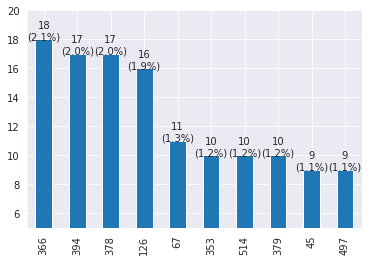

In [24]:
applied_sum = train[train["applied"]==1].count()[0] # 지원한 전체 공고 수

train.loc[train["applied"]==1, "jobID"].value_counts()[:10].plot(kind="bar", ylim=[5,20])

object_cnt = train.loc[train["applied"]==1, "jobID"].value_counts()[:10]
for x,y,z in zip(range(10), object_cnt.values, object_cnt.values/applied_sum*100):
    plt.annotate(f"{y}\n({round(z,1)}%)", xy=(x,y), textcoords="data", ha="center")

가장 많이 지원한 곳은 366번 공고이며 18명의 지원자가 있음




In [25]:
train.loc[train["applied"]==1, "jobID"].value_counts()[:10].keys()

Int64Index([366, 394, 378, 126, 67, 353, 514, 379, 45, 497], dtype='int64')

In [26]:
job_companies[job_companies["jobID"].isin([366, 394, 378, 126, 67, 353, 514, 379, 45, 497])]

,companyID,jobID,companySize
27,27,353,NaN
40,39,379,11-50
126,93,366,101-200
132,96,378,101-200
140,102,394,201-500
206,53,45,1-10
310,93,67,101-200
341,175,126,NaN
377,131,497,51-100
478,93,514,101-200


* 태그 변환

In [27]:
tags.index = tags["tagID"]
tags_to_dict = tags["keyword"].to_dict()
str(tags_to_dict)[:300]

"{'602d1305678a8d5fdb372271e980da6a': 'Amazon Web Services(AWS)', 'e3251075554389fe91d17a794861d47b': 'Tensorflow', 'a1d50185e7426cbb0acad1e6ca74b9aa': 'Docker', '884d79963bd8bc0ae9b13a1aa71add73': 'Git', '4122cb13c7a474c1976c9706ae36521d': 'Python', '6e7d2da6d3953058db75714ac400b584': 'Go', '208e43f"

In [28]:
user_tags["tagID"].replace(tags_to_dict, inplace=True)
user_tags

,userID,tagID
0,72,JUnit
1,72,Spring
2,72,WebSocket
3,72,Spring Boot
4,72,JavaScript
...,...,...
2577,126,MySQL
2578,126,GitHub
2579,126,JavaScript
2580,126,Git


In [29]:
temp = user_tags.groupby(["tagID"])["tagID"].count()
user_tags_grouped_df = pd.DataFrame({"tag":temp.index, "count":temp})
user_tags_grouped_df.reset_index(drop=True, inplace=True)

In [30]:
other_row = pd.DataFrame({"tag":['others'],
              "count": [user_tags_grouped_df.sort_values(by="count")["count"].iloc[:-10].sum()]})
user_tags_grouped_df = pd.concat([user_tags_grouped_df, other_row], axis=0, ignore_index=True)
user_tags_grouped_df.sort_values(by="count", ascending=False).iloc[:11]

,tag,count
345,others,1840
159,Java,115
163,JavaScript,113
204,MySQL,93
217,Node.js,81
279,Spring,76
241,Python,56
142,HTML,55
251,ReactJS,51
34,Android,51


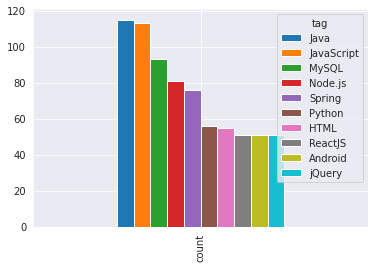

In [31]:
user_tags_grouped_df.sort_values(by="count", ascending=False).iloc[1:11].set_index('tag').T.plot(kind='bar')

* 가장 많이 선택된 상위 10개의 태그 + others
* 풀스택 관련 언어가 상위 10위를 차지하고 있다.


In [32]:
job_tags["tagID"].replace(tags_to_dict, inplace=True)
job_tags

,jobID,tagID
0,1,Ruby
1,2,Node.js
2,2,JavaScript
3,3,HTML
4,3,Vue.js
...,...,...
3472,710,C++
3473,711,Swift
3474,711,Realm
3475,711,Firebase


In [33]:
temp = job_tags.groupby(["tagID"])["tagID"].count()
job_tags_grouped_df = pd.DataFrame({"tag":temp.index, "count":temp})
job_tags_grouped_df.reset_index(drop=True, inplace=True)

other_row = pd.DataFrame({"tag":['others'],
              "count": [job_tags_grouped_df.sort_values(by="count")["count"].iloc[:-15].sum()]})
job_tags_grouped_df = pd.concat([job_tags_grouped_df, other_row], axis=0, ignore_index=True)
job_tags_grouped_df.sort_values(by="count", ascending=False).iloc[:16]

,tag,count
240,others,1727
114,JavaScript,219
113,Java,197
170,Python,187
150,Node.js,153
141,MySQL,143
177,ReactJS,131
102,HTML,115
52,CSS,114
88,Git,103


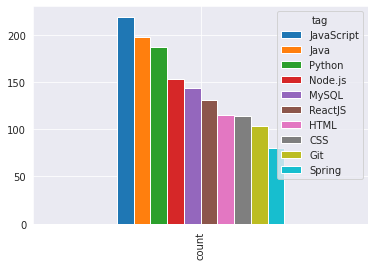

In [34]:
job_tags_grouped_df.sort_values(by="count", ascending=False).iloc[1:11].set_index('tag').T.plot(kind='bar')

* 구직공고에서 원하는 기술도 대부분 풀스택 기술인 것으로 보인다.

In [35]:
job_tags_count_df = job_tags.groupby(["tagID"])[["tagID"]].count()
job_tags_count_df = job_tags_count_df.rename(columns={"tagID": "tag_counts"})
job_tags_count_df = job_tags_count_df.reset_index()
job_tags_count_df

,tagID,tag_counts
0,.NET,9
1,ASP,2
2,ASP.NET,4
3,AWS Backup,1
4,AWS CloudWatch,1
...,...,...
235,iOS,38
236,jQuery,45
237,mSQL,1
238,styled-components,2


In [36]:
job_tags_count_df = pd.merge(job_tags, job_tags_count_df, how="left")
job_tags_count_df

,jobID,tagID,tag_counts
0,1,Ruby,28
1,2,Node.js,153
2,2,JavaScript,219
3,3,HTML,115
4,3,Vue.js,71
...,...,...,...
3472,710,C++,50
3473,711,Swift,41
3474,711,Realm,4
3475,711,Firebase,12


사용된 빈도와 태그명을 튜플로 묶은 후 공고ID 별로 리스트로 만듦

In [37]:
job_tags_count_df["tag"] = job_tags_count_df["tagID"] + "," + job_tags_count_df["tag_counts"].astype(str)
job_tags_count_df["tag"] = job_tags_count_df["tag"].apply(lambda x: (int(x.split(",")[1]), x.split(",")[0]))
job_tags_count_df

,jobID,tagID,tag_counts,tag
0,1,Ruby,28,"(28, Ruby)"
1,2,Node.js,153,"(153, Node.js)"
2,2,JavaScript,219,"(219, JavaScript)"
3,3,HTML,115,"(115, HTML)"
4,3,Vue.js,71,"(71, Vue.js)"
...,...,...,...,...
3472,710,C++,50,"(50, C++)"
3473,711,Swift,41,"(41, Swift)"
3474,711,Realm,4,"(4, Realm)"
3475,711,Firebase,12,"(12, Firebase)"


In [38]:
job_tag_lists = job_tags_count_df.groupby("jobID")[["tag"]].apply(lambda x: x["tag"].tolist()).rename("jobTag").reindex()
job_tag_lists = pd.DataFrame({"jobTag": job_tag_lists})
job_tag_lists

,jobTag
jobID,
1,"[(28, Ruby), (52, Ruby on Rails)]"
2,"[(153, Node.js), (219, JavaScript), (103, Git)]"
3,"[(115, HTML), (71, Vue.js), (36, AngularJS), (..."
4,"[(5, Apache Spark), (3, Apache Hadoop)]"
5,"[(55, Django), (68, Docker), (27, AWS EC2), (2..."
...,...
729,"[(59, Android)]"
730,"[(55, React Native)]"
731,"[(41, Swift)]"


In [39]:
job_tag_lists[job_tag_lists["jobTag"].apply(lambda x: len(x))>=3]

,jobTag
jobID,
2,"[(153, Node.js), (219, JavaScript), (103, Git)]"
3,"[(115, HTML), (71, Vue.js), (36, AngularJS), (..."
5,"[(55, Django), (68, Docker), (27, AWS EC2), (2..."
6,"[(197, Java), (28, SQL), (153, Node.js), (50, ..."
7,"[(35, Webpack), (131, ReactJS), (50, TypeScrip..."
...,...
703,"[(36, REST API), (187, Python), (13, GCP(Googl..."
706,"[(187, Python), (49, PHP), (143, MySQL)]"
707,"[(18, Objective-C), (50, C++), (38, iOS)]"


In [40]:
job_tag_lists_top3 = job_tag_lists["jobTag"].apply(lambda x: list(x))
job_tag_lists_top3 = job_tag_lists_top3.apply(lambda x: sorted(x)[-3:]).reset_index()
job_tag_lists_top3

,jobID,jobTag
0,1,"[(28, Ruby), (52, Ruby on Rails)]"
1,2,"[(103, Git), (153, Node.js), (219, JavaScript)]"
2,3,"[(115, HTML), (131, ReactJS), (219, JavaScript)]"
3,4,"[(3, Apache Hadoop), (5, Apache Spark)]"
4,5,"[(153, Node.js), (187, Python), (219, JavaScri..."
...,...,...
728,729,"[(59, Android)]"
729,730,"[(55, React Native)]"
730,731,"[(41, Swift)]"
731,732,"[(55, React Native)]"


In [41]:
user_tags_count_df = pd.merge(user_tags, user_tags_grouped_df, left_on="tagID", right_on="tag")[["userID", "tag", "count"]]
user_tags_count_df 

,userID,tag,count
0,72,JUnit,10
1,88,JUnit,10
2,128,JUnit,10
3,31,JUnit,10
4,70,JUnit,10
...,...,...,...
2577,85,beautifulsoup,1
2578,148,Sketch,1
2579,146,Google Cloud Storage for Firebase,1
2580,126,Apache Zeppelin,1


In [42]:
user_tags_count_df["tag_counts"] = user_tags_count_df["tag"] + "," + user_tags_count_df["count"].astype(str)
user_tags_count_df["tag_counts"] = user_tags_count_df["tag_counts"].apply(lambda x: (int(x.split(",")[1]), x.split(",")[0]))
user_tags_count_df

,userID,tag,count,tag_counts
0,72,JUnit,10,"(10, JUnit)"
1,88,JUnit,10,"(10, JUnit)"
2,128,JUnit,10,"(10, JUnit)"
3,31,JUnit,10,"(10, JUnit)"
4,70,JUnit,10,"(10, JUnit)"
...,...,...,...,...
2577,85,beautifulsoup,1,"(1, beautifulsoup)"
2578,148,Sketch,1,"(1, Sketch)"
2579,146,Google Cloud Storage for Firebase,1,"(1, Google Cloud Storage for Firebase)"
2580,126,Apache Zeppelin,1,"(1, Apache Zeppelin)"


In [43]:
user_tag_lists = user_tags_count_df.groupby("userID")[["tag_counts"]].apply(lambda x: x["tag_counts"].tolist()).rename("userTags")
user_tag_lists = pd.DataFrame({"userTags": user_tag_lists})
user_tag_lists.reset_index(inplace=True)
user_tag_lists

,userID,userTags
0,1,"[(51, Android), (11, OpenCV), (37, MongoDB), (..."
1,2,"[(76, Spring), (32, Spring Boot), (113, JavaSc..."
2,3,"[(51, Android), (15, Raspberry Pi), (35, AWS E..."
3,4,"[(113, JavaScript), (51, Android), (15, Raspbe..."
4,5,"[(76, Spring), (32, Spring Boot), (113, JavaSc..."
...,...,...
191,192,"[(76, Spring), (56, Python), (115, Java), (19,..."
192,193,"[(76, Spring), (32, Spring Boot), (113, JavaSc..."
193,194,"[(10, JUnit), (76, Spring), (7, WebSocket), (3..."
194,195,"[(51, Android), (15, Raspberry Pi), (93, MySQL..."


In [44]:
user_tag_lists[user_tag_lists["userTags"].apply(lambda x: len(x))<3]

,userID,userTags
91,92,"[(19, C#)]"
94,95,"[(113, JavaScript)]"
104,105,"[(51, Android), (115, Java)]"
105,106,"[(93, MySQL), (115, Java)]"
135,136,"[(4, Google Cloud Firestore)]"
142,143,"[(1, MATLAB)]"
169,170,"[(9, React Native)]"
185,186,"[(27, C++)]"


In [45]:
user_tag_lists["userTags"] = user_tag_lists["userTags"].apply(lambda x: sorted(x)[-3:]).reset_index(drop=True)
user_tag_lists

,userID,userTags
0,1,"[(56, Python), (81, Node.js), (115, Java)]"
1,2,"[(93, MySQL), (113, JavaScript), (115, Java)]"
2,3,"[(35, AWS EC2), (51, Android), (81, Node.js)]"
3,4,"[(81, Node.js), (113, JavaScript), (115, Java)]"
4,5,"[(93, MySQL), (113, JavaScript), (115, Java)]"
...,...,...
191,192,"[(56, Python), (76, Spring), (115, Java)]"
192,193,"[(93, MySQL), (113, JavaScript), (115, Java)]"
193,194,"[(93, MySQL), (113, JavaScript), (115, Java)]"
194,195,"[(35, PHP), (51, Android), (93, MySQL)]"


* 276개의 회사에서 733개의 채용공고를 냄

In [46]:
# 채용 공고와 태그, 회사 정보를 병합
job_info = pd.merge(job_tag_lists,job_companies, on="jobID")
job_info

,jobID,jobTag,companyID,companySize
0,1,"[(28, Ruby), (52, Ruby on Rails)]",35,11-50
1,2,"[(153, Node.js), (219, JavaScript), (103, Git)]",61,51-100
2,3,"[(115, HTML), (71, Vue.js), (36, AngularJS), (...",154,1-10
3,4,"[(5, Apache Spark), (3, Apache Hadoop)]",40,201-500
4,5,"[(55, Django), (68, Docker), (27, AWS EC2), (2...",155,1-10
...,...,...,...,...
728,729,"[(59, Android)]",26,101-200
729,730,"[(55, React Native)]",189,1-10
730,731,"[(41, Swift)]",67,101-200
731,732,"[(55, React Native)]",189,1-10


결측치의 개수:  90


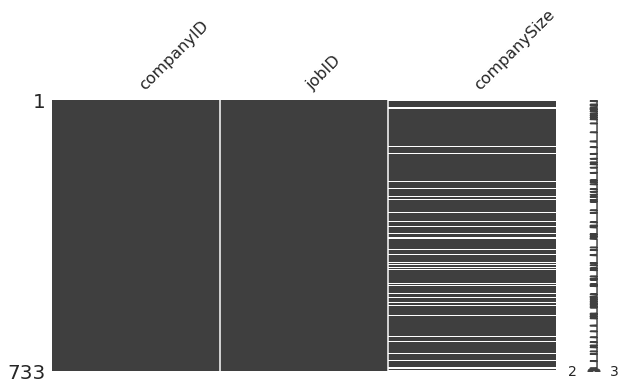

In [47]:
missingno.matrix(job_companies, figsize=(10,5))
print("결측치의 개수: ",job_companies["companySize"].isna().sum())

* 90개의 회사의 companySize 정보가 비어있음
* 채용 공고의 개수로 회사 규모를 알 수 있을까?

In [48]:
nullSize_companies = job_companies[job_companies["companySize"].isna()].jobID.tolist()

In [49]:
company_by_jobCount_df = job_info.reset_index().groupby("companyID")[["jobID"]].count().reset_index()
company_by_jobCount_df.rename(columns={"jobID":"jobCount"},inplace=True)
company_by_jobCount_df = pd.merge(company_by_jobCount_df, job_companies[["companyID", "companySize"]], on="companyID", how="right")
company_by_jobCount_df

,companyID,jobCount,companySize
0,1,4,NaN
1,2,2,11-50
2,3,1,101-200
3,4,1,1-10
4,5,2,NaN
...,...,...,...
728,18,18,51-100
729,33,9,51-100
730,225,2,NaN
731,276,1,NaN


In [50]:
company_by_jobCount_df["companySize"].unique()

array([nan, '11-50', '101-200', '1-10', '51-100', '1000 이상', '201-500',
       '501-1000'], dtype=object)

In [51]:
crosstable = pd.crosstab(company_by_jobCount_df["jobCount"], company_by_jobCount_df["companySize"].fillna("NaN"))
crosstable[['NaN', '1-10', '11-50','51-100', '101-200', '201-500', '501-1000', '1000 이상']]

companySize,NaN,1-10,11-50,51-100,101-200,201-500,501-1000,1000 이상
jobCount,,,,,,,,
1,12,27,49,13,9,6,1,3
2,16,16,48,26,12,6,0,0
3,9,12,54,12,15,3,0,0
4,20,20,16,16,12,0,4,0
5,10,5,15,5,0,5,0,0
6,6,12,18,0,0,6,0,0
7,0,0,0,7,0,7,7,0
8,8,8,16,16,0,8,0,0
9,9,0,18,9,0,0,0,0


* 회사 규모가 결측치인 곳은 1~9 개의 채용 공고를 냈으며 규모가 200이하인 기업들도 대체로 1 ~ 10개의 채용 공고가 있다.
* 회사 규모가 나오지 않는다는 것은 신생 기업이거나 소규모 기업일 가능성이 높음
* 따라서 1-10 으로 결측치를 대체하기로 함

In [52]:
job_info = job_info.fillna("1-10")
job_info

,jobID,jobTag,companyID,companySize
0,1,"[(28, Ruby), (52, Ruby on Rails)]",35,11-50
1,2,"[(153, Node.js), (219, JavaScript), (103, Git)]",61,51-100
2,3,"[(115, HTML), (71, Vue.js), (36, AngularJS), (...",154,1-10
3,4,"[(5, Apache Spark), (3, Apache Hadoop)]",40,201-500
4,5,"[(55, Django), (68, Docker), (27, AWS EC2), (2...",155,1-10
...,...,...,...,...
728,729,"[(59, Android)]",26,101-200
729,730,"[(55, React Native)]",189,1-10
730,731,"[(41, Swift)]",67,101-200
731,732,"[(55, React Native)]",189,1-10


In [53]:
job_tags

,jobID,tagID
0,1,Ruby
1,2,Node.js
2,2,JavaScript
3,3,HTML
4,3,Vue.js
...,...,...
3472,710,C++
3473,711,Swift
3474,711,Realm
3475,711,Firebase


* applied_list : 유저가 지원한 회사 리스트
* user_tag_list : 유저의 태그 리스트
* job_info : 채용공고를 낸 회사정보와 태그 리스트

In [54]:
job_info = job_info.set_index('jobID')
jobTag1 = job_info["jobTag"].apply(lambda x: x[0][1])
jobTag2 = job_info[job_info["jobTag"].apply(lambda x: len(x))>1]["jobTag"].apply(lambda x: x[1][1])
jobTag3 = job_info[job_info["jobTag"].apply(lambda x: len(x))>2]["jobTag"].apply(lambda x: x[2][1])

분리한 태그 병합

In [55]:
job_info["jobTag1"] = jobTag1
job_info["jobTag2"] = jobTag2
job_info["jobTag3"] = jobTag3
job_info

,jobTag,companyID,companySize,jobTag1,jobTag2,jobTag3
jobID,,,,,,
1,"[(28, Ruby), (52, Ruby on Rails)]",35,11-50,Ruby,Ruby on Rails,NaN
2,"[(153, Node.js), (219, JavaScript), (103, Git)]",61,51-100,Node.js,JavaScript,Git
3,"[(115, HTML), (71, Vue.js), (36, AngularJS), (...",154,1-10,HTML,Vue.js,AngularJS
4,"[(5, Apache Spark), (3, Apache Hadoop)]",40,201-500,Apache Spark,Apache Hadoop,NaN
5,"[(55, Django), (68, Docker), (27, AWS EC2), (2...",155,1-10,Django,Docker,AWS EC2
...,...,...,...,...,...,...
729,"[(59, Android)]",26,101-200,Android,NaN,NaN
730,"[(55, React Native)]",189,1-10,React Native,NaN,NaN
731,"[(41, Swift)]",67,101-200,Swift,NaN,NaN


In [56]:
job_info_copy = job_info.fillna('')
job_info_copy

,jobTag,companyID,companySize,jobTag1,jobTag2,jobTag3
jobID,,,,,,
1,"[(28, Ruby), (52, Ruby on Rails)]",35,11-50,Ruby,Ruby on Rails,
2,"[(153, Node.js), (219, JavaScript), (103, Git)]",61,51-100,Node.js,JavaScript,Git
3,"[(115, HTML), (71, Vue.js), (36, AngularJS), (...",154,1-10,HTML,Vue.js,AngularJS
4,"[(5, Apache Spark), (3, Apache Hadoop)]",40,201-500,Apache Spark,Apache Hadoop,
5,"[(55, Django), (68, Docker), (27, AWS EC2), (2...",155,1-10,Django,Docker,AWS EC2
...,...,...,...,...,...,...
729,"[(59, Android)]",26,101-200,Android,,
730,"[(55, React Native)]",189,1-10,React Native,,
731,"[(41, Swift)]",67,101-200,Swift,,


In [57]:
job_info_copy["jobTag"] = job_info_copy["jobTag1"].astype(str) +', '+ job_info_copy["jobTag2"].astype(str) +', '+ job_info_copy["jobTag3"].astype(str)
job_info_copy["jobTag"]

jobID
1              Ruby, Ruby on Rails, 
2           Node.js, JavaScript, Git
3            HTML, Vue.js, AngularJS
4      Apache Spark, Apache Hadoop, 
5            Django, Docker, AWS EC2
                   ...              
729                      Android, , 
730                 React Native, , 
731                        Swift, , 
732                 React Native, , 
733                        Swift, , 
Name: jobTag, Length: 733, dtype: object

In [58]:
company_size_dict = {x:i for i, x in enumerate(sorted(job_info.companySize.unique(), key=lambda x: int((x.split("-"))[0].split()[0])))}
company_size_dict

{'1-10': 0,
 '1000 이상': 6,
 '101-200': 3,
 '11-50': 1,
 '201-500': 4,
 '501-1000': 5,
 '51-100': 2}

In [59]:
test_job

,userID,jobID
0,49,422
1,172,18
2,167,50
3,80,322
4,17,364
...,...,...
2430,54,29
2431,115,212
2432,127,41
2433,115,230


In [60]:
# test_job
temp = pd.merge(test_job, job_companies, left_on="jobID", right_on="jobID").fillna("1-10")
temp = pd.merge(temp, user_tags_count_df.groupby("userID")[["tag"]].apply(lambda x: x["tag"].tolist()).rename("userTags"), left_on="userID", right_on="userID")
test_job = pd.merge(temp, job_tags_count_df.groupby("jobID")[["tagID"]].apply(lambda x: x["tagID"].tolist()).rename("jobTags"), left_on="jobID", right_on="jobID")
test_job["companySize"] = test_job["companySize"].replace(company_size_dict)
test_job

,userID,jobID,companyID,companySize,userTags,jobTags
0,49,422,110,1,"[MySQL, MongoDB, CSS, ReactJS, Python, Node.js...","[MongoDB, Git, Node.js, AWS S3, C#, HTML, Type..."
1,49,150,78,1,"[MySQL, MongoDB, CSS, ReactJS, Python, Node.js...","[Git, ExpressJS, JavaScript, MySQL, Node.js]"
2,99,150,78,1,"[Spring, Android, MySQL, OpenCV, CSS, C++, Jav...","[Git, ExpressJS, JavaScript, MySQL, Node.js]"
3,128,150,78,1,"[JUnit, Spring, Spring Boot, JavaScript, MySQL...","[Git, ExpressJS, JavaScript, MySQL, Node.js]"
4,36,150,78,1,"[Spring, JavaScript, Git, AWS RDS, MySQL, Boot...","[Git, ExpressJS, JavaScript, MySQL, Node.js]"
...,...,...,...,...,...,...
2430,183,211,40,4,"[JavaScript, CSS3, MongoDB, Pandas, CSS, React...","[Linux, Apache Spark, Python]"
2431,66,643,51,1,"[JavaScript, Android, Java, Node.js, Kotlin]","[Java, MySQL, Android]"
2432,66,390,100,2,"[JavaScript, Android, Java, Node.js, Kotlin]","[Android, Kotlin, Java]"
2433,48,710,201,1,"[JavaScript, Raspberry Pi, GitHub, OpenCV, CSS...","[Qt, C++]"


In [61]:
job_meta_dict = job_info_copy[["companySize","jobTag"]].to_dict()
str(job_meta_dict)[:300]

"{'companySize': {1: '11-50', 2: '51-100', 3: '1-10', 4: '201-500', 5: '1-10', 6: '101-200', 7: '11-50', 8: '101-200', 9: '1-10', 10: '11-50', 11: '51-100', 12: '11-50', 13: '11-50', 14: '101-200', 15: '1-10', 16: '51-100', 17: '1-10', 18: '51-100', 19: '201-500', 20: '11-50', 21: '201-500', 22: '11-"

* 지원한 공고를 기준으로 할 경우 한번도 지원하지 않은 공고가 전체 데이터의 반이상을 차지하기 때문에 태그를 기준으로 유사한 공고를 구하기로 함.

태스트에 등장하는 고유 채용공고 591개, train에 없는 공고 25개


In [62]:
len(test_job["jobID"].unique())

591

In [63]:
len(set(sorted(train["jobID"].unique())) & set(sorted(test_job["jobID"].unique())))

566

In [64]:
temp = train.groupby("jobID")[["applied"]].sum().reset_index()
temp[temp["applied"]==0]

,jobID,applied
0,1,0
3,4,0
4,5,0
12,13,0
14,15,0
...,...,...
693,719,0
695,721,0
697,723,0
701,727,0


아무도 지원하지 않은 공고 362개

In [65]:
tags_dict = {x:i+1 for i, x in enumerate(tags["keyword"].values)}
str(tags_dict)[:100]

"{'Amazon Web Services(AWS)': 1, 'Tensorflow': 2, 'Docker': 3, 'Git': 4, 'Python': 5, 'Go': 6, 'Deep "

In [66]:
job_tags["tagID"] = job_tags["tagID"].replace(tags_dict)

In [67]:
job_by_tags_list = job_tags.groupby("tagID")[["jobID"]].apply(lambda x: x["jobID"].tolist()).rename("jobID")

In [68]:
job_by_tags_list

tagID
1      [36, 60, 63, 76, 152, 209, 210, 245, 252, 285,...
2      [20, 143, 193, 457, 472, 539, 558, 565, 574, 6...
3      [5, 25, 58, 85, 117, 131, 141, 176, 183, 190, ...
4      [7, 16, 38, 52, 53, 68, 89, 93, 103, 104, 150,...
5      [8, 18, 36, 40, 49, 51, 72, 73, 82, 84, 95, 11...
                             ...                        
249                                                [383]
250                                                [406]
251                                                [406]
252                                                [594]
253                                                [188]
Name: jobID, Length: 240, dtype: object

In [69]:
job2vec_dataset = []
for job_list in job_by_tags_list:
    meta_list = []
    for job_id in job_list:
        job_meta_1 = "jobID:" + str(job_id)
        job_meta_2 = "jobTag:" + job_meta_dict["jobTag"][job_id]
        
        meta_list.append(job_meta_1)
        meta_list.append(job_meta_2)
    job2vec_dataset.append(meta_list)

In [70]:
str(job2vec_dataset)[:300]

"[['jobID:36', 'jobTag:NoSQL, Amazon Web Services(AWS), Python', 'jobID:60', 'jobTag:MyBatis, jQuery, AWS EC2', 'jobID:63', 'jobTag:Amazon Web Services(AWS), Node.js, MySQL', 'jobID:76', 'jobTag:Amazon Web Services(AWS), Python, Linux', 'jobID:152', 'jobTag:Python, Nginx, Amazon Web Services(AWS)', '"

word2vec으로 채용공고의 메타정보를 임베딩 해서 유사한 채용공고를 후보로 만든다.


In [71]:

model = Word2Vec(job2vec_dataset,
                 size=200,
                 window=20,      
                 sg=1,      # CBoW 또는 skip-gram(1)
                 hs=0,      # 최적화 방법 negative sampling(0) 또는 hierarchical softmax 
                 negative=20,   
                 min_count=1,
                 iter=50)

In [72]:
model.wv.most_similar("jobID:1", topn=10)

[('jobTag:Ruby, Ruby on Rails, ', 0.9121835827827454),
 ('jobID:691', 0.8171674609184265),
 ('jobID:37', 0.8109441995620728),
 ('jobTag:Redis, Ruby, Elasticsearch', 0.8029480576515198),
 ('jobID:137', 0.7926441431045532),
 ('jobID:35', 0.7921372652053833),
 ('jobTag:Ruby, JavaScript, Ruby on Rails', 0.7874622344970703),
 ('jobTag:JavaScript, HTML, Ruby on Rails', 0.7853167653083801),
 ('jobTag:Ruby on Rails, Ruby, ', 0.7090970277786255),
 ('jobID:53', 0.6957418918609619)]

In [73]:
job_info_copy[job_info_copy.index.isin([1, 37, 691, 137, 35, 405])][["companySize", "jobTag"]]

,companySize,jobTag
jobID,,
1,11-50,"Ruby, Ruby on Rails,"
35,11-50,"JavaScript, HTML, Ruby on Rails"
37,11-50,"Redis, Ruby, Elasticsearch"
137,11-50,"Ruby, JavaScript, Ruby on Rails"
405,1-10,"Ruby, Ruby on Rails,"
691,11-50,"Ruby on Rails, Ruby, JavaScript"


In [74]:
item2item = {}

k = 10
not_in_count = 0
for job_id in train["jobID"].values:
    item2item[job_id] = []
    try:
        sim_list = model.wv.most_similar("jobID:" + str(job_id), topn=k+10)
        for job_tup in sim_list:
            tup_info = job_tup[0].split(":")
            if (tup_info[0] == "jobID") and (len(item2item[job_id]) < 10):
                item2item[job_id].append(int(tup_info[1]))
    except:
        not_in_count += 1
      #  print(f"word '{str(job_id)}' not in vocabulary.")

In [75]:
str(item2item)[:300]

'{372: [465, 691, 393, 336, 138, 217, 108, 149, 1, 229], 458: [459, 421, 425, 31, 512, 418, 494, 445, 490, 524], 527: [488, 586, 498, 635, 601, 288, 571, 684, 240, 602], 316: [352, 261, 325, 311, 186, 371, 287, 302, 236, 338], 49: [8, 594, 81, 47, 55, 71, 40, 56, 98, 64], 285: [723, 303, 257, 289, 18'

유사한 공고들의 메타 정보 확인

In [76]:
job_info_copy[job_info_copy.index.isin([372, 465, 691, 393, 336, 138, 217, 108, 149, 1, 229])][["companySize", "jobTag"]]

,companySize,jobTag
jobID,,
1,11-50,"Ruby, Ruby on Rails,"
108,11-50,"Ruby on Rails, Ruby, JavaScript"
138,11-50,"Ruby on Rails, Elasticsearch, Ruby"
149,11-50,"HTML, Ruby on Rails, CSS"
217,51-100,"Ruby on Rails, Go, Python"
229,51-100,"Node.js, Python, Go"
336,11-50,"Ruby on Rails, Database, SQL"
372,11-50,"Ruby on Rails, Ruby,"
393,11-50,"Ruby on Rails, Database, SQL"


태그가 비슷한 공고들인 것을 확인할 수 있다.

### 가설1: 유저와 채용공고 간 겹치는 태그가 많을 수록 지원을 많이 할 것이다.
- jobTag와 userTag의 교집합을 합집합으로 나눈 값을 tag_ratio로 만들고 applied와 상관관계 확인

유저 태그와 채용공고의 태그가 겹치는 비율을 tag_ratio로 만듦

In [77]:
job_tags_count_df.groupby("jobID")[["tagID"]].apply(lambda x: x["tagID"].tolist()).rename("jobTags")

jobID
1                                  [Ruby, Ruby on Rails]
2                             [Node.js, JavaScript, Git]
3      [HTML, Vue.js, AngularJS, JavaScript, CSS, Rea...
4                          [Apache Spark, Apache Hadoop]
5      [Django, Docker, AWS EC2, JavaScript, BitBucke...
                             ...                        
729                                            [Android]
730                                       [React Native]
731                                              [Swift]
732                                       [React Native]
733                                              [Swift]
Name: jobTags, Length: 733, dtype: object

In [78]:
user_tags_count_df.groupby("userID")[["tag"]].apply(lambda x: x["tag"].tolist()).rename("userTags")

userID
1      [Android, OpenCV, MongoDB, ReactJS, Python, Ja...
2      [Spring, Spring Boot, JavaScript, MySQL, CSS3,...
3      [Android, Raspberry Pi, AWS EC2, Node.js, Ubun...
4      [JavaScript, Android, Raspberry Pi, Flask, CSS...
5      [Spring, Spring Boot, JavaScript, AWS RDS, MyS...
                             ...                        
192       [Spring, Python, Java, C#, MyBatis, Thymeleaf]
193    [Spring, Spring Boot, JavaScript, MySQL, Boots...
194    [JUnit, Spring, WebSocket, Spring Boot, JavaSc...
195    [Android, Raspberry Pi, MySQL, Linux, PHP, Mar...
196    [JavaScript, GitHub, MongoDB, ReactJS, Mongoos...
Name: userTags, Length: 196, dtype: object

In [79]:
train = pd.merge(train, job_tags_count_df.groupby("jobID")[["tagID"]].apply(lambda x: x["tagID"].tolist()).rename("jobTags"), left_on="jobID", right_on="jobID")

In [80]:
train = pd.merge(train, user_tags_count_df.groupby("userID")[["tag"]].apply(lambda x: x["tag"].tolist()).rename("userTags"), left_on="userID", right_on="userID")

In [81]:
train["union"] = train["jobTags"] + train["userTags"]
train["tag_ratio"] = (train["union"].apply(lambda x: len(x)) - train["union"].apply(lambda x: len(set(x))))/ train["userTags"].apply(lambda x: len(x))
train

,userID,jobID,applied,jobTags,userTags,union,tag_ratio
0,1,372,0,"[Ruby on Rails, Ruby]","[Android, OpenCV, MongoDB, ReactJS, Python, Ja...","[Ruby on Rails, Ruby, Android, OpenCV, MongoDB...",0.000000
1,1,730,0,[React Native],"[Android, OpenCV, MongoDB, ReactJS, Python, Ja...","[React Native, Android, OpenCV, MongoDB, React...",0.000000
2,1,413,0,"[Java, Kotlin]","[Android, OpenCV, MongoDB, ReactJS, Python, Ja...","[Java, Kotlin, Android, OpenCV, MongoDB, React...",0.076923
3,1,464,0,"[NoSQL, Amazon Web Services(AWS), Java, REST A...","[Android, OpenCV, MongoDB, ReactJS, Python, Ja...","[NoSQL, Amazon Web Services(AWS), Java, REST A...",0.076923
4,1,59,0,"[C++, C#]","[Android, OpenCV, MongoDB, ReactJS, Python, Ja...","[C++, C#, Android, OpenCV, MongoDB, ReactJS, P...",0.000000
...,...,...,...,...,...,...,...
5995,191,439,0,"[Django, MongoDB, Vue.js, ReactJS, HTML, Java,...","[Spring, JavaScript, Bootstrap, CSS, Python, J...","[Django, MongoDB, Vue.js, ReactJS, HTML, Java,...",0.545455
5996,191,490,0,"[PostgreSQL, Python, AWS Lambda]","[Spring, JavaScript, Bootstrap, CSS, Python, J...","[PostgreSQL, Python, AWS Lambda, Spring, JavaS...",0.090909
5997,191,359,0,"[Redis, jQuery, Elasticsearch, Apache Tomcat, ...","[Spring, JavaScript, Bootstrap, CSS, Python, J...","[Redis, jQuery, Elasticsearch, Apache Tomcat, ...",0.272727
5998,195,134,1,"[PostgreSQL, MariaDB, SQLAlchemy, Nginx, Naver...","[Android, Raspberry Pi, MySQL, Linux, PHP, Mar...","[PostgreSQL, MariaDB, SQLAlchemy, Nginx, Naver...",0.250000


In [82]:
temp

,jobID,applied
0,1,0
1,2,7
2,3,3
3,4,0
4,5,0
...,...,...
703,729,1
704,730,1
705,731,0
706,732,1


In [86]:
test_job["union"] = test_job["jobTags"] + test_job["userTags"]
test_job["tag_ratio"] = (test_job["union"].apply(lambda x: len(x)) - test_job["union"].apply(lambda x: len(set(x))))/ test_job["userTags"].apply(lambda x: len(x))
test_job = test_job[["userID", "jobID","companyID","companySize","tag_ratio"]]
test_job

,userID,jobID,companyID,companySize,tag_ratio
0,49,422,110,1,0.230769
1,49,150,78,1,0.153846
2,99,150,78,1,0.083333
3,128,150,78,1,0.150000
4,36,150,78,1,0.136364
...,...,...,...,...,...
2430,183,211,40,4,0.062500
2431,66,643,51,1,0.400000
2432,66,390,100,2,0.600000
2433,48,710,201,1,0.045455


In [87]:
train["tag_ratio"].describe()

count    6000.000000
mean        0.120155
std         0.131489
min         0.000000
25%         0.000000
50%         0.090909
75%         0.166667
max         1.000000
Name: tag_ratio, dtype: float64

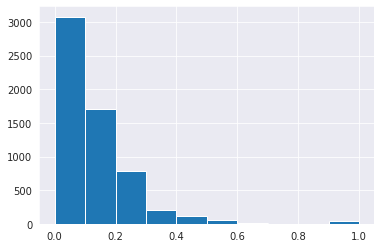

In [88]:
train["tag_ratio"].hist()

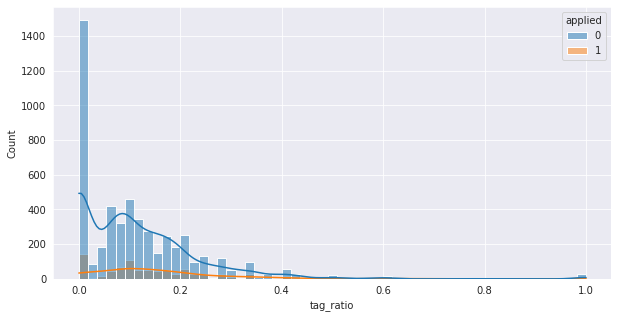

In [110]:
plt.figure(figsize=(10,5))
sns.histplot(train, x="tag_ratio", hue="applied", kde=True, legend=True)

In [92]:
train = pd.merge(train, job_info, left_on="jobID", right_on="jobID")[["userID", "jobID", "tag_ratio", "companyID", "companySize", "applied"]]
train["companySize"] = train["companySize"].replace(company_size_dict)
train

,userID,jobID,tag_ratio,companyID,companySize,applied
0,1,372,0.000000,35,1,0
1,33,372,0.000000,35,1,0
2,22,372,0.000000,35,1,0
3,158,372,0.000000,35,1,1
4,91,372,0.000000,35,1,0
...,...,...,...,...,...,...
5995,188,606,0.100000,40,4,0
5996,57,606,0.142857,40,4,1
5997,86,76,0.083333,16,2,1
5998,50,169,0.285714,151,0,0


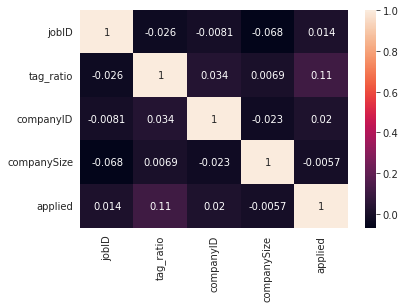

In [93]:
sns.heatmap(train[["jobID", "tag_ratio", "companyID", "companySize", "applied"]].corr(), annot=True, cbar=True)

겹치는 태그의 비율은 지원 여부와 관계가 없는 것으로 보인다.

item2item에 있는 비슷한 공고에 지원 했는지 안했는지 여부를 feature로 만듦

In [136]:
str(item2item)[:100]

'{372: [465, 691, 393, 336, 138, 217, 108, 149, 1, 229], 458: [459, 421, 425, 31, 512, 418, 494, 445,'

In [95]:
applied_list

userID
1      [357, 378, 171, 122, 155, 126, 47, 434]
2                                           []
3                              [527, 730, 134]
4                     [138, 183, 10, 134, 654]
5                           [45, 320, 52, 303]
                        ...                   
192                       [171, 378, 126, 122]
193                            [713, 378, 518]
194                             [122, 717, 19]
195                                      [134]
196                     [514, 125, 19, 371, 2]
Length: 196, dtype: object

In [96]:
applied_list[43]

[43, 57, 308, 47, 426, 453, 318]

In [97]:
item2item[336]

[393, 372, 79, 189, 247, 149, 57, 165, 310, 483]

In [98]:
job_info_copy[job_info_copy.index.isin([514, 125, 19, 371, 2])][["companySize", "jobTag"]]

,companySize,jobTag
jobID,,
2,51-100,"Node.js, JavaScript, Git"
19,201-500,"CSS, JavaScript, HTML"
125,1-10,"CSS, JavaScript, ES6"
371,11-50,"JavaScript, ReactJS, Vue.js"
514,101-200,"JavaScript, CSS, Vue.js"


In [99]:
test_job.iloc[1632]

userID          43.000000
jobID          129.000000
companyID       69.000000
companySize      1.000000
tag_ratio        0.111111
Name: 1632, dtype: float64

In [100]:
applied_list = applied_list.reset_index()
applied_list.columns = ["userID","applied_job_list"]
applied_list

,userID,applied_job_list
0,1,"[357, 378, 171, 122, 155, 126, 47, 434]"
1,2,[]
2,3,"[527, 730, 134]"
3,4,"[138, 183, 10, 134, 654]"
4,5,"[45, 320, 52, 303]"
...,...,...
191,192,"[171, 378, 126, 122]"
192,193,"[713, 378, 518]"
193,194,"[122, 717, 19]"
194,195,[134]


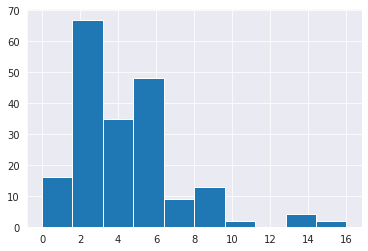

In [105]:
applied_list["applied_job_list"].apply(lambda x: len(x)).hist()

In [129]:
applied_list[applied_list["applied_job_list"].apply(lambda x: len(x))==0]

,userID,applied_job_list
1,2,[]
79,80,[]
91,92,[]
125,126,[]
130,131,[]


In [126]:
applied_list["applied_job_list"].apply(lambda x: len(x)).describe()

count    196.000000
mean       4.372449
std        2.690736
min        0.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       16.000000
Name: applied_job_list, dtype: float64

In [101]:
pd.merge(train, applied_list, left_on="userID", right_on="userID")

,userID,jobID,tag_ratio,companyID,companySize,applied,applied_job_list
0,1,372,0.000000,35,1,0,"[357, 378, 171, 122, 155, 126, 47, 434]"
1,1,730,0.000000,189,0,0,"[357, 378, 171, 122, 155, 126, 47, 434]"
2,1,413,0.076923,45,1,0,"[357, 378, 171, 122, 155, 126, 47, 434]"
3,1,464,0.076923,70,0,0,"[357, 378, 171, 122, 155, 126, 47, 434]"
4,1,59,0.000000,40,4,0,"[357, 378, 171, 122, 155, 126, 47, 434]"
...,...,...,...,...,...,...,...
5995,51,425,0.100000,55,1,1,"[163, 728, 425, 32, 428]"
5996,51,248,0.200000,238,2,0,"[163, 728, 425, 32, 428]"
5997,51,5,0.050000,155,0,0,"[163, 728, 425, 32, 428]"
5998,51,541,0.000000,195,1,0,"[163, 728, 425, 32, 428]"


In [138]:
applied_list.head()

,userID,applied_job_list
0,1,"[357, 378, 171, 122, 155, 126, 47, 434]"
1,2,[]
2,3,"[527, 730, 134]"
3,4,"[138, 183, 10, 134, 654]"
4,5,"[45, 320, 52, 303]"


In [150]:
job_info_copy[job_info_copy.index.isin([357, 378, 171, 122, 155, 126, 47, 434])][["companySize", "jobTag"]]

,companySize,jobTag
jobID,,
47,11-50,"TypeScript, GraphQL, Node.js"
122,1-10,"ExpressJS, Node.js, ReactJS"
126,1-10,"NoSQL, Java, OOP"
155,11-50,"ReactJS, Android, JavaScript"
171,201-500,"Kubernetes, GraphQL, TypeScript"
357,11-50,"Redux.js, RxJS, HTML"
378,101-200,"JIRA, Java, Git"
434,201-500,"Sass(SCSS), ReactJS, TypeScript"


In [160]:
train[(train["applied"]==0)& (train["userID"]==1)].groupby("userID")[["jobID"]].apply(lambda x: x["jobID"].tolist()).values

In [164]:
job_info_copy[job_info_copy.index.isin([372, 730, 413, 464, 59, 228, 381, 467, 324, 134, 431, 501, 152, 511, 465, 673, 60, 507, 529])][["companySize", "jobTag"]]

,companySize,jobTag
jobID,,
59,201-500,"C++, C#,"
60,11-50,"MyBatis, jQuery, AWS EC2"
134,11-50,"PostgreSQL, MariaDB, SQLAlchemy"
152,11-50,"Python, Nginx, Amazon Web Services(AWS)"
228,11-50,"HTML, JavaScript, CSS"
324,11-50,"CSS, ReactJS, Webpack"
372,11-50,"Ruby on Rails, Ruby,"
381,201-500,"Scala, Python, C#"
413,11-50,"Java, Kotlin,"


In [134]:
user_tags.loc[user_tags["userID"]==1, "tagID"].values

array(['MongoDB', 'Docker', 'Java', 'Jenkins', 'ExpressJS', 'OpenCV',
       'SQLite', 'ReactJS', 'Machine Learning', 'Android', 'Linux',
       'Node.js', 'Python'], dtype=object)

유저가 선택한 태그가 있더라도 어떤 태그와 함께 있느냐에 따라 지원여부가 달라지는 것으로 보인다.
* 혹시 태그의 중복으로 특정 태그에 대한 선호도를 알 수 있을까.. 내일해보자